<a href="https://colab.research.google.com/github/hezhengda/google-colab/blob/main/Pytorch_for_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics of Pytorch

**Traditional programming**: input + algorithm --> output

**New paradigm**: input + output --> algorithm (if we cannot write the algorithm and there are many outliers)



## Pytorch jargons

**Tensor**: A tensor can be a number, a vector, a matrix or any n-dimensional array (so it is just another name for n-dimensional array [NDA])

The difference between tensor and n-dimensional array:
* The size of tensor should not change
* When you try to do a tensor operation, do it in the tensor type because it is implemented in C++ (which means really fast), but if you do it in python, then it is really slow.

In [ ]:
# import pytorch
import torch

In [ ]:
# set a number
a = torch.tensor(4.0)
print(a,'|', a.dtype,'|', a.shape)

# set a vector
b = torch.tensor([1, 2, 3, 4])
print(b,'|',  b.dtype,'|',  b.shape)

# set a matrix
c = torch.tensor([[1, 2], [3, 4], [5, 6]])
print(c,'|',  c.dtype,'|',  c.shape)

tensor(4.) | torch.float32 | torch.Size([])
tensor([1, 2, 3, 4]) | torch.int64 | torch.Size([4])
tensor([[1, 2],
        [3, 4],
        [5, 6]]) | torch.int64 | torch.Size([3, 2])


## Create tensors

The `requires_grad` is important to understand. This is used for improving the efficiency of your code, because when your code gets more complex, the time on calculating gradients becomes larger, so we need to find a way to tell the program which gradient we need and which we needn't, if we set `requires_grad=True` to a variable, that means we want to have its derivative. 

In [ ]:
x = torch.tensor(3.)
w = torch.tensor(4., requires_grad=True) # what's the meaning of this "requires_grad"?
b = torch.tensor(5., requires_grad=True)

In [ ]:
# Arithmatic operations
y = w * x + b
print('{}, {}'.format(y, y.requires_grad))

17.0, True


In [ ]:
# compute derivatives --> for gradient descent
y.backward()

In [ ]:
# display the gradients
print('dy/dx:', x.grad) # output None because x doesn't have "requires_grad"
print('dy/dw:', w.grad) # 3 because x = 3
print('dy/db:', b.grad) # 1 because the coefficient of b is 1

dy/dx: None
dy/dw: tensor(3.)
dy/db: tensor(1.)


## Questions

**Problems**
Now let's try to solve some questions:

1. What if in $y=w\times x+b$, the `w`, `x` and `b` are all 1-dimensional array? What about two-dimensional array? What will `w.grad` looks like?

  * When the tensor is 1D tensor, there is no gradient ?

2. What if we have the **chain role**, which means: $y = w\times x + b$, $w = m\times p + q$? What will happen if we want to calcualte `p.grad`?

  * If you make sure that you have the leaf node, then the gradient is correct, but if not, then you need to use other settings, e.g. `retain_grad()` on the non-leaf tensor.

In [ ]:
# Problem 1 - tensor operation is by element
x = torch.tensor([1.0, 2.0])
w = torch.tensor([1.0, 2.0], requires_grad=True)
b = torch.tensor([1.0, 2.0], requires_grad=True)
y = w * x + b
print(y)
print('dy/dw:', w.grad)

tensor([2., 6.], grad_fn=<AddBackward0>)
dy/dw: None


In [ ]:
# Problem 2 - chain role 
x = torch.tensor(1.0)
w = torch.tensor(2.0, requires_grad=True)
b = torch.tensor(5.0, requires_grad=True)

c = w + b 
c.retain_grad() # since c is a non-leaf node, then you need to use 
y = c * w * x + b

# calculate gradient
y.backward()
print('dy/dw: ', w.grad)
print('dy/dc: ', c.grad)

dy/dw:  tensor(9.)
dy/dc:  tensor(2.)


## Interoperability with Numpy

If you want to change numpy array to tensor, you need to use `torch.from_numpy(array)`.

Convert from pytorch tensor to numpy array: `y.numpy()`

In [ ]:
# numpy is written in C++, which means this is very efficient
import numpy as np

In [ ]:
x = np.array([[1, 2],[3, 4]])
y = torch.from_numpy(x)
print(y, y.dtype)
z = y.numpy()
print(z, z.dtype)

tensor([[1, 2],
        [3, 4]]) torch.int64
[[1 2]
 [3 4]] int64


# Linear Regression of PyTorch

Linear Regression means that we want to rationalize the data by using a linear model: $y = wx+b$. (w: weights, b: bias) We know all the $(x,y)$, now we want to find the optimal coefficient $(m,b)$. Notice that in here, `w` could be a matrix and `b` could also be a vector when `x` and `y` are vectors.

This is a really simple assumption and usually it is the first step of our modeling process.

Our first problem is to predict the yield of apple and orange by giving a certain temperature, rainfall and humidity.

## Set inputs and targets

In [ ]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

In [ ]:
# Targets (yield_apples, yield_oranges)
targets = np.array([[56, 70],
                    [81, 101],
                    [119, 133],
                    [22, 37],
                    [103, 119]], dtype='float32')

The reason why we seperate the input variables and target variables is because we need to treat them differently in our program. Also we've created numpy arrays, because this is typically how you would work with training data: read some CSV files as numpy arrays, do some processing, and then convert them to Pytorch tensors to do further training.

In [ ]:
# convert numpy array for torch tensors
inputs_torch = torch.from_numpy(inputs)
targets_torch = torch.from_numpy(targets)

In [ ]:
# start the value of weight and bias from a random value
# since we have 2 targets and 3 inputs, then our weight should be a 2x3 matrix
# our bias should have same size as our targets
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(1, 2, requires_grad=True)
print(w)
print(b)

tensor([[ 1.3066,  0.9426, -1.5872],
        [-1.2522,  1.0184, -1.1143]], requires_grad=True)
tensor([[0.3716, 0.0434]], requires_grad=True)


When our weight is a matrix, then our linear regression can be written as:
$$y = x \cdot w^T + b$$

The size of our weight matrix is related to the number of features and the number of outputs.

**Make sure that the dimension of your matrix is correct! Really important!**

## Build our model

In this case it is a linear regression model, but in the future, the model can be really complex (e.g. A neural network model)

In [ ]:
# define the model
def model(x):
  return x @ w.t() + b # @ means matrix multiplication

In [ ]:
# predictions of our model 
preds = model(inputs_torch)
print(preds) # really, really bad ... right now ...

tensor([[100.3761,  17.6190],
        [133.1410,  10.2199],
        [ 80.8693, -55.7864],
        [156.0216, 105.1184],
        [101.3740, -43.1640]])


In [ ]:
print(targets_torch)

tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


## Calculate the loss function

The **mean-square error** can be defined as:

$$mse=\frac{1}{N}\sum_{i=1}^N(t_1^i-t_2^i)^2$$

In [ ]:
# define the mean-square error
def mse(t1, t2):
  diff = t1 - t2
  return torch.sum(diff*diff)/diff.numel() # diff*diff: element-wise multiplication; diff.numel() number of elements in diff

## Calculate the gradient --> Gradient Descent

In [ ]:
w = torch.randn(2, 3, requires_grad=True)
b = torch.randn(1, 2, requires_grad=True)
threshold = 10
lr = 1e-5 # learning_rate
ind = 0 #
preds = model(inputs_torch)
loss = mse(preds, targets_torch)
print(loss)
while loss > threshold:
    new_preds = model(inputs_torch)
    loss = mse(new_preds, targets_torch)
    loss.backward()
    with torch.no_grad():
        w -= lr * w.grad
        b -= lr * b.grad
        w.grad.zero_()
        b.grad.zero_()
    ind += 1
    print('Epoch {} ... loss = {}'.format(ind, loss))

In [ ]:
preds = model(inputs_torch)
print(preds)
print(targets_torch)

tensor([[ 58.2112,  69.5565],
        [ 81.6339, 100.3739],
        [118.3174, 134.8474],
        [ 26.1825,  31.0243],
        [ 98.1191, 122.4509]], grad_fn=<AddBackward0>)
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.]])


In here I need to say: in pytorch, `a = a - 1` is not the same as `a -= 1`.

* `a = a - 1` means first we evaluate `a-1`, then we create another tensor `a`, which has different reference number 

* `a -= 1` means we only evaluate `a-1`, but the reference for `a` is the same.

In [ ]:
a = torch.tensor([1, 2])
print('original id = {}'.format(id(a)))
b = torch.tensor([2, 2])
a -= b
print('After a = a - b, id = {}'.format(id(a)))

original id = 139940533485432
After a = a - b, id = 139940533485432


## Use pytorch built-in function

In [ ]:
import torch.nn as nn 
# nn means neural network

In [ ]:
# Input (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43], 
                   [91, 88, 64], 
                   [87, 134, 58], 
                   [102, 43, 37], 
                   [69, 96, 70], 
                   [74, 66, 43], 
                   [91, 87, 65], 
                   [88, 134, 59], 
                   [101, 44, 37], 
                   [68, 96, 71], 
                   [73, 66, 44], 
                   [92, 87, 64], 
                   [87, 135, 57], 
                   [103, 43, 36], 
                   [68, 97, 70]], 
                  dtype='float32')

# Targets (apples, oranges)
targets = np.array([[56, 70], 
                    [81, 101], 
                    [119, 133], 
                    [22, 37], 
                    [103, 119],
                    [57, 69], 
                    [80, 102], 
                    [118, 132], 
                    [21, 38], 
                    [104, 118], 
                    [57, 69], 
                    [82, 100], 
                    [118, 134], 
                    [20, 38], 
                    [102, 120]], 
                   dtype='float32')

inputs = torch.from_numpy(inputs)
targets = torch.from_numpy(targets)

In [ ]:
# dataset and dataloader (batching)

from torch.utils.data import TensorDataset

# define our dataset 
train_ds = TensorDataset(inputs, targets)

# dataloader
from torch.utils.data import DataLoader

# define batch size 
batch_size = 10
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [ ]:
# look at 1 batch
for xb, yb in train_dl:
    print(xb)
    print(yb)
    break

tensor([[ 87., 134.,  58.],
        [ 73.,  67.,  43.],
        [ 73.,  66.,  44.],
        [101.,  44.,  37.],
        [ 91.,  87.,  65.],
        [103.,  43.,  36.],
        [ 87., 135.,  57.],
        [ 68.,  96.,  71.],
        [ 74.,  66.,  43.],
        [ 69.,  96.,  70.]])
tensor([[119., 133.],
        [ 56.,  70.],
        [ 57.,  69.],
        [ 21.,  38.],
        [ 80., 102.],
        [ 20.,  38.],
        [118., 134.],
        [104., 118.],
        [ 57.,  69.],
        [103., 119.]])


In [ ]:
# define model
model = nn.Linear(3, 2) # 3 is the number of your features, 2 is the number of your outputs
print(model.weight)
print(model.bias)

Parameter containing:
tensor([[-0.0298,  0.4024, -0.1152],
        [ 0.5231, -0.2843, -0.1735]], requires_grad=True)
Parameter containing:
tensor([0.1466, 0.4071], requires_grad=True)


In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0298,  0.4024, -0.1152],
         [ 0.5231, -0.2843, -0.1735]], requires_grad=True),
 Parameter containing:
 tensor([0.1466, 0.4071], requires_grad=True)]

In [ ]:
# make predictions
preds = model(inputs_torch)
print(preds)

tensor([[19.9765, 12.0850],
        [25.4707, 11.8874],
        [44.7912, -2.2405],
        [10.1458, 35.1170],
        [28.6545, -2.9349]], grad_fn=<AddmmBackward>)


In [ ]:
# define loss function 
import torch.nn.functional as F

loss_fn = F.mse_loss

loss = loss_fn(model(inputs_torch), targets_torch)
print(loss)

tensor(6001.2764, grad_fn=<MseLossBackward>)


In [ ]:
# define optimizer
opt = torch.optim.SGD(model.parameters(), lr=1e-5) # lr means learning-rate

In [ ]:
# train the model
# utility function to train the model 
def fit(num_epochs, train_dl, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            # 1. Generate prediction
            preds = model(xb)

            # 2. Calculate the loss 
            loss = loss_fn(preds, yb)

            # 3. Compute gradients 
            loss.backward()

            # 4. Update parameters using gradients
            opt.step()

            # 5. Reset the gradients to zero 
            opt.zero_grad() 

        if (epoch+1)%10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
             

In [ ]:
fit(100, train_dl, model, loss_fn, opt)

Epoch [10/100], Loss: 42.0496
Epoch [20/100], Loss: 44.0107
Epoch [30/100], Loss: 80.4472
Epoch [40/100], Loss: 71.6844
Epoch [50/100], Loss: 45.9663
Epoch [60/100], Loss: 40.9093
Epoch [70/100], Loss: 49.8164
Epoch [80/100], Loss: 39.4097
Epoch [90/100], Loss: 34.3259
Epoch [100/100], Loss: 18.9639


In [ ]:
preds = model(inputs)
print(preds)
print(targets)

tensor([[ 57.6456,  71.5131],
        [ 79.2267,  97.5071],
        [123.2662, 137.0268],
        [ 24.5356,  44.1636],
        [ 94.8529, 109.6299],
        [ 56.3971,  70.5016],
        [ 78.5486,  97.0258],
        [123.2827, 137.3443],
        [ 25.7841,  45.1751],
        [ 95.4234, 110.1600],
        [ 56.9675,  71.0317],
        [ 77.9782,  96.4957],
        [123.9443, 137.5082],
        [ 23.9652,  43.6335],
        [ 96.1015, 110.6414]], grad_fn=<AddmmBackward>)
tensor([[ 56.,  70.],
        [ 81., 101.],
        [119., 133.],
        [ 22.,  37.],
        [103., 119.],
        [ 57.,  69.],
        [ 80., 102.],
        [118., 132.],
        [ 21.,  38.],
        [104., 118.],
        [ 57.,  69.],
        [ 82., 100.],
        [118., 134.],
        [ 20.,  38.],
        [102., 120.]])


## Summary

So in order to make a machine learning model, we need:

* Number of Epochs
* Training Data (features + targets)
* Testing Data
* Model
* Loss function
* Optimizer

In this example, we can put each statement in the following:

* Number of Epochs
    ``` python
    num_epochs = 100
    ```
* Training Data (features + targets)
    ``` python
    # Input (temp, rainfall, humidity)
    inputs = np.array([[73, 67, 43], 
                    [91, 88, 64], 
                    [87, 134, 58], 
                    [102, 43, 37], 
                    [69, 96, 70], 
                    [74, 66, 43], 
                    [91, 87, 65], 
                    [88, 134, 59], 
                    [101, 44, 37], 
                    [68, 96, 71], 
                    [73, 66, 44], 
                    [92, 87, 64], 
                    [87, 135, 57], 
                    [103, 43, 36], 
                    [68, 97, 70]], 
                    dtype='float32')

    # Targets (apples, oranges)
    targets = np.array([[56, 70], 
                        [81, 101], 
                        [119, 133], 
                        [22, 37], 
                        [103, 119],
                        [57, 69], 
                        [80, 102], 
                        [118, 132], 
                        [21, 38], 
                        [104, 118], 
                        [57, 69], 
                        [82, 100], 
                        [118, 134], 
                        [20, 38], 
                        [102, 120]], 
                    dtype='float32')

    inputs = torch.from_numpy(inputs)
    targets = torch.from_numpy(targets)

    # dataset and dataloader (batching)

    from torch.utils.data import TensorDataset

    # define our dataset 
    train_ds = TensorDataset(inputs, targets)

    # dataloader
    from torch.utils.data import DataLoader

    # define batch size 
    batch_size = 10
    train_dl = DataLoader(train_ds, batch_size, shuffle=True)
    ```
* Testing Data
* Model

    ``` python
    import torch.nn as nn
    # define model
    model = nn.Linear(3, 2) # 3 is the number of your features, 2 is the number of your outputs
    print(model.weight)
    print(model.bias)
    ```
* Loss function

    ``` python
    # define loss function 
    import torch.nn.functional as F

    loss_fn = F.mse_loss

    loss = loss_fn(model(inputs_torch), targets_torch)
    ```

* Optimizer
    ``` python
    # define optimizer
    opt = torch.optim.SGD(model.parameters(), lr=1e-5) # lr means learning-rate
    ```

We can write a general training model `fit()`:

``` python
# train the model
# utility function to train the model 
def fit(num_epochs, train_dl, model, loss_fn, opt):
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            # 1. Generate prediction
            preds = model(xb)

            # 2. Calculate the loss 
            loss = loss_fn(preds, yb)

            # 3. Compute gradients 
            loss.backward()

            # 4. Update parameters using gradients
            opt.step()

            # 5. Reset the gradients to zero 
            opt.zero_grad() 

        if (epoch+1)%10 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss))
```

Once we have the `num_epochs`, `train_dl`, `model`, `loss_fn` and `opt`, then we can start training out machine learning model.

# Image Classification and logistic regression

In [ ]:
import torch
import torchvision
from torchvision.datasets import MNIST
import numpy as np

In [ ]:
# Download training dataset
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
len(dataset)

60000

In [ ]:
test_dataset = MNIST(root='data/', train=False)
len(test_dataset)

10000

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F3F3340C898>, 5)

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

Label: 3


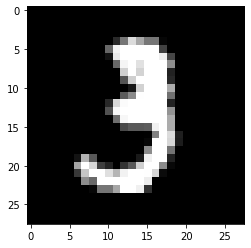

In [ ]:
image, label = dataset[10]
plt.imshow(image, cmap='gray')
print('Label:', label)

In [ ]:
# transform the MNIST figure to a tensor
import torchvision.transforms as transforms

In [ ]:
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor())

In [ ]:
img_tensor, label = dataset[0] 
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 5


In [ ]:
print(img_tensor[:, 10:15, 10:15])
print(torch.max(img_tensor), torch.min(img_tensor))

tensor([[[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
         [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
         [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
         [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
         [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]]])
tensor(1.) tensor(0.)


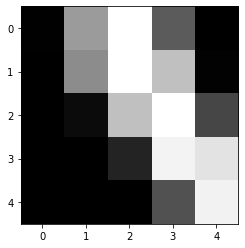

In [ ]:
plt.imshow(img_tensor[0, 10:15, 10:15], cmap='gray')

In [ ]:
# split the dataset into three parts: (1) training set (2) test set (3) validation set
def split_indices(total_num, validation_portion):
    validation_num = total_num * validation_portion
    index = np.random.permutation(total_num) # get a random permutation
    return index[int(validation_num):], index[:int(validation_num)]
# [:1] means from 0 to 1; [1:] means from 1 to the end

In [ ]:
train_indices, val_indices = split_indices(len(dataset), 0.2)
print(len(train_indices), len(val_indices))

48000 12000


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader 

In [ ]:
batch_size = 100 

# training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_loader = DataLoader(dataset, batch_size, sampler=train_sampler)

# validation sampler 
val_sampler = SubsetRandomSampler(val_indices)
val_loader = DataLoader(dataset, batch_size, sampler=val_sampler)

In [ ]:
# We shall build the linear regression model
import torch.nn as nn

input_size = 28*28 # input
num_classes = 10 # output 0~9

model = nn.Linear(input_size, num_classes)

# Logistic regression model
print(model.weight.shape)
print(model.bias.shape)

torch.Size([10, 784])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
    print(labels)
    print(images.shape)
    outputs = model(images)
    break

tensor([2, 4, 6, 3, 3, 2, 4, 6, 6, 9, 2, 8, 0, 8, 4, 1, 2, 5, 0, 7, 3, 5, 7, 4,
        7, 4, 6, 6, 7, 6, 9, 8, 7, 9, 4, 2, 8, 2, 3, 8, 4, 0, 0, 1, 9, 1, 2, 0,
        0, 4, 3, 9, 9, 0, 9, 9, 3, 8, 1, 2, 5, 6, 8, 3, 0, 4, 3, 2, 9, 5, 7, 2,
        0, 6, 9, 6, 1, 7, 4, 5, 8, 7, 3, 1, 1, 0, 9, 6, 9, 5, 5, 0, 3, 7, 5, 2,
        8, 0, 7, 1])
torch.Size([100, 1, 28, 28])


RuntimeError: ignored

In [ ]:
# This is how you build any complex model in pytorch

# flat the array: reshape(-1, 784)
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__() # If you have a parent class, you need this
        self.linear = nn.Linear(input_size, num_classes) # now we can combine different models
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784) # -1 can help us deal with any dimensions
        out = self.linear(xb)
        return out

model = MnistModel()

In [ ]:
print(model.linear.weight.shape, model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[-0.0188, -0.0009, -0.0252,  ..., -0.0073,  0.0111, -0.0120],
         [-0.0055, -0.0067,  0.0198,  ..., -0.0048,  0.0184, -0.0320],
         [ 0.0290,  0.0023, -0.0033,  ..., -0.0282,  0.0243, -0.0188],
         ...,
         [-0.0304, -0.0149, -0.0309,  ...,  0.0050, -0.0169, -0.0091],
         [ 0.0128, -0.0025, -0.0349,  ..., -0.0281, -0.0261,  0.0330],
         [ 0.0246,  0.0051, -0.0341,  ..., -0.0008,  0.0244, -0.0110]],
        requires_grad=True), Parameter containing:
 tensor([ 0.0108,  0.0346,  0.0054,  0.0223,  0.0066,  0.0062, -0.0055, -0.0154,
         -0.0183,  0.0238], requires_grad=True)]

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    break

print('outputs.shape: ', outputs.shape)
print('Sample outputs: \n', outputs[:2].data)

outputs.shape:  torch.Size([100, 10])
Sample outputs: 
 tensor([[-0.1621,  0.0015,  0.0527,  0.1942, -0.0078,  0.2721,  0.1660, -0.2523,
         -0.1167,  0.2649],
        [ 0.1355, -0.0366, -0.1294,  0.1795,  0.1016,  0.0494,  0.0086,  0.0543,
         -0.0868, -0.2678]])


We want the 10 numbers to represent probability, so we need:

* all values > 0
* all values < 1

We can use 'softmax' to convert anything into probability.

$$S(y_i)=\frac{e^{y_i}}{\sum_je^{y_j}}$$

Softmax function can increase the difference between each guess.

In [ ]:
# import softmax
import torch.nn.functional as F

In [ ]:
probs = F.softmax(outputs, dim=1) # dim=1, reduce the dimension to 1
print('Sample probabilities: \n', probs[:2].data)
print('Sum: ', torch.sum(probs[0]).item())

Sample probabilities: 
 tensor([[0.0804, 0.0947, 0.0997, 0.1148, 0.0938, 0.1241, 0.1116, 0.0735, 0.0841,
         0.1232],
        [0.1135, 0.0956, 0.0871, 0.1186, 0.1097, 0.1041, 0.1000, 0.1047, 0.0909,
         0.0758]])
Sum:  1.0


In [ ]:
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(max_probs)

tensor([5, 3, 5, 5, 5, 5, 4, 5, 9, 1, 9, 5, 5, 3, 4, 5, 3, 4, 3, 6, 9, 1, 1, 5,
        5, 4, 3, 1, 9, 9, 5, 5, 6, 8, 5, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 6, 3,
        3, 5, 4, 5, 5, 5, 8, 5, 3, 5, 1, 5, 5, 9, 1, 6, 1, 3, 3, 3, 5, 5, 5, 3,
        5, 1, 3, 5, 1, 8, 1, 1, 0, 3, 5, 5, 5, 5, 3, 1, 3, 6, 5, 4, 1, 3, 5, 5,
        6, 1, 5, 5])
tensor([0.1241, 0.1186, 0.1334, 0.1212, 0.1391, 0.1151, 0.1291, 0.1364, 0.1238,
        0.1218, 0.1522, 0.1233, 0.1188, 0.1216, 0.1191, 0.1259, 0.1468, 0.1117,
        0.1333, 0.1197, 0.1336, 0.1131, 0.1287, 0.1464, 0.1455, 0.1206, 0.1223,
        0.1379, 0.1214, 0.1218, 0.1152, 0.1447, 0.1225, 0.1271, 0.1483, 0.1130,
        0.1131, 0.1599, 0.1268, 0.1381, 0.1315, 0.1351, 0.1334, 0.1334, 0.1434,
        0.1264, 0.1263, 0.1214, 0.1367, 0.1306, 0.1242, 0.1355, 0.1291, 0.1368,
        0.1221, 0.1652, 0.1266, 0.1342, 0.1388, 0.1364, 0.1565, 0.1159, 0.1200,
        0.1314, 0.1120, 0.1263, 0.1259, 0.1230, 0.1564, 0.1402, 0.1263, 0.1189,
        0.1594, 0.1

In [ ]:
labels

tensor([7, 2, 3, 4, 1, 1, 6, 7, 0, 9, 0, 2, 0, 4, 5, 0, 2, 0, 2, 4, 7, 1, 4, 1,
        0, 8, 6, 5, 0, 9, 4, 2, 4, 2, 0, 6, 9, 1, 1, 0, 7, 3, 9, 0, 8, 2, 4, 8,
        2, 2, 5, 1, 1, 5, 2, 0, 6, 5, 5, 0, 6, 3, 5, 9, 9, 4, 6, 9, 6, 5, 9, 7,
        0, 0, 6, 5, 6, 4, 2, 5, 5, 7, 8, 8, 9, 7, 6, 1, 2, 7, 5, 1, 4, 5, 2, 9,
        9, 1, 5, 5])

In [ ]:
# Evaluation matrix and loss function
def accuracy(l1, l2):
    return torch.sum(l1==l2).item() / len(l1)

In [ ]:
accuracy(preds, labels) # first: 0.11 --> really bad

0.11

The loss function we need to use something differentiable, and also reflect the probability of the whole prediction list.

We need to use Shannon entropy (or cross entropy):

$$D(\hat{y}, y)=-\sum_jy_j \ln(\hat{y}_j)$$

$y_i$ is the label, and $\hat{y}_i$ is the predicted value.



In [ ]:
loss_fn = F.cross_entropy
loss = loss_fn(outputs, labels)
print(loss)

tensor(2.2906, grad_fn=<NllLossBackward>)


In [ ]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)



I would like to write a more complicated class

In [13]:
import torch
import torchvision
from torchvision.datasets import MNIST
import numpy as np

In [2]:
dataset = MNIST(root='data/', download=True)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
len(dataset)

60000

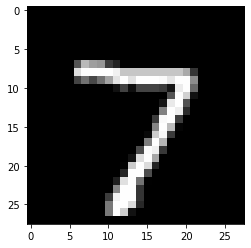

In [11]:
import matplotlib.pyplot as plt
plt.imshow(test_set[0][0], cmap='gray')

In [97]:
# prepare the test set, training set and validation set

# test set
test_set = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_image = MNIST(root='data/', train=False)

# transform --> we need to transform the image to the tensor (for pytorch to process)
import torchvision.transforms as transforms
dataset = MNIST(root='data/',
                train=True,
                transform=transforms.ToTensor())

# split the dataset into training set and validation set 
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [50000, 10000])

# train in batch
from torch.utils.data import DataLoader 

batch_size = 128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(valid_ds, batch_size)

In [32]:
# Now let's define our model
import torch.nn as nn

input_size = 28*28
num_classes = 10

# build a class
class MnistModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
    
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out

model = MnistModel(input_size=input_size, num_classes=num_classes)

In [57]:
for images, labels in train_loader:
    images = images.reshape(128, 784)
    outputs = model(images)
    print(outputs[:2])
    break

tensor([[-0.2770,  0.1041,  0.1568,  0.0648,  0.0801, -0.2447,  0.3354,  0.1122,
          0.4452,  0.0014],
        [ 0.0474, -0.1564,  0.3331, -0.1350,  0.0986, -0.0975, -0.1440,  0.1524,
          0.5404, -0.0332]], grad_fn=<SliceBackward>)


**Some procedures in pytorch and machine learning**

For each machine learning, we have two classes: (1) Dataset (2) Model

In dataset, we have: (1) construct the dataset (2) identify the training, validation and test groups. (3) add & delete datasets

In the model, we have: (1) build the model (2) forward (3) backward (optimization) (4) train (5) evaluation

In [64]:
import torch.nn.functional as F

probs = F.softmax(outputs, dim=1)
max_probs, preds = torch.max(probs, dim=1)
print(preds)
print(labels)
print(max_probs)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

print(accuracy(outputs, labels))

tensor([8, 8, 6, 8, 6, 8, 6, 6, 8, 6, 8, 6, 2, 8, 2, 2, 2, 6, 6, 2, 8, 7, 2, 1,
        2, 3, 6, 6, 6, 6, 2, 8, 8, 8, 6, 2, 6, 8, 8, 5, 6, 9, 1, 6, 2, 8, 8, 8,
        2, 1, 8, 8, 1, 6, 8, 2, 4, 8, 2, 2, 6, 8, 8, 6, 2, 8, 6, 6, 8, 8, 8, 6,
        2, 8, 6, 2, 4, 2, 6, 6, 8, 2, 2, 8, 6, 8, 6, 6, 8, 1, 8, 8, 8, 2, 2, 6,
        6, 8, 8, 8, 2, 8, 5, 2, 6, 2, 8, 6, 2, 6, 2, 6, 1, 8, 6, 6, 6, 8, 8, 8,
        8, 2, 8, 6, 1, 6, 8, 5])
tensor([2, 4, 0, 4, 2, 9, 2, 9, 9, 1, 7, 1, 8, 4, 7, 5, 4, 9, 6, 9, 3, 7, 3, 2,
        7, 7, 1, 5, 1, 2, 3, 3, 3, 0, 1, 6, 1, 9, 5, 7, 6, 3, 4, 3, 8, 5, 0, 8,
        9, 0, 0, 8, 6, 2, 5, 3, 9, 3, 9, 4, 8, 4, 2, 0, 7, 8, 2, 8, 8, 4, 4, 5,
        3, 5, 5, 7, 4, 9, 6, 1, 4, 7, 2, 7, 4, 2, 1, 0, 9, 6, 8, 3, 7, 3, 4, 2,
        1, 3, 4, 8, 7, 4, 1, 9, 0, 5, 2, 1, 6, 7, 7, 1, 6, 8, 2, 5, 5, 8, 0, 8,
        5, 9, 3, 7, 2, 4, 0, 7])
tensor([0.1412, 0.1575, 0.1267, 0.1233, 0.1238, 0.1260, 0.1207, 0.1411, 0.1260,
        0.1361, 0.1189, 0.1297, 0.1377, 0.1612, 0.1317

In [66]:
loss_fn = F.cross_entropy

loss = loss_fn(outputs, labels)
print(loss)

tensor(2.3310, grad_fn=<NllLossBackward>)


In [68]:
# problem independent part
def fit(epochs, learning_rate, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), learning_rate)
    history = []

    for epoch in range(epochs):

        # Training phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # validation phase 
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [72]:
class MnistModel(nn.Module): # derived form nn.Module
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)

    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch # since batch is a tuple
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss 
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print('Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}'.format(epoch, 
                                                                     result['val_loss'], 
                                                                     result['val_acc']))

model = MnistModel(input_size, num_classes)

In [73]:
result0 = evaluate(model, val_loader)
result0

{'val_acc': 0.13221915066242218, 'val_loss': 2.3005659580230713}

In [75]:
history1 = fit(50, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1180, val_acc: 0.8056
Epoch [1], val_loss: 1.0452, val_acc: 0.8134
Epoch [2], val_loss: 0.9857, val_acc: 0.8196
Epoch [3], val_loss: 0.9361, val_acc: 0.8257
Epoch [4], val_loss: 0.8941, val_acc: 0.8294
Epoch [5], val_loss: 0.8580, val_acc: 0.8334
Epoch [6], val_loss: 0.8269, val_acc: 0.8358
Epoch [7], val_loss: 0.7996, val_acc: 0.8394
Epoch [8], val_loss: 0.7756, val_acc: 0.8416
Epoch [9], val_loss: 0.7540, val_acc: 0.8448
Epoch [10], val_loss: 0.7348, val_acc: 0.8463
Epoch [11], val_loss: 0.7175, val_acc: 0.8487
Epoch [12], val_loss: 0.7017, val_acc: 0.8500
Epoch [13], val_loss: 0.6873, val_acc: 0.8520
Epoch [14], val_loss: 0.6741, val_acc: 0.8532
Epoch [15], val_loss: 0.6620, val_acc: 0.8543
Epoch [16], val_loss: 0.6508, val_acc: 0.8554
Epoch [17], val_loss: 0.6404, val_acc: 0.8565
Epoch [18], val_loss: 0.6307, val_acc: 0.8576
Epoch [19], val_loss: 0.6217, val_acc: 0.8591
Epoch [20], val_loss: 0.6133, val_acc: 0.8605
Epoch [21], val_loss: 0.6054, val_acc: 0.861

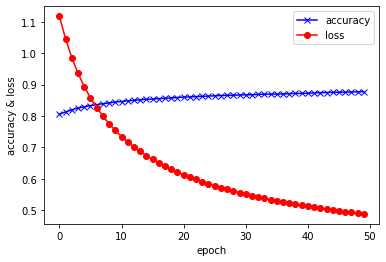

In [81]:
history1
val_acc_history = [a['val_acc'] for a in history1]
val_loss_history = [a['val_loss'] for a in history1]
epochs = [i for i in range(len(history1))]
plt.plot(epochs, val_acc_history, '-x', color='b', label='accuracy')
plt.plot(epochs, val_loss_history, '-o', color='r', label='loss')
plt.xlabel('epoch')
plt.ylabel('accuracy & loss')
plt.legend()
plt.show()

In [82]:
# save our coefficients
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [83]:
!ls -la

total 52
drwxr-xr-x 1 root root  4096 Dec 27 16:18 .
drwxr-xr-x 1 root root  4096 Dec 27 14:48 ..
drwxr-xr-x 1 root root  4096 Dec 21 17:29 .config
drwxr-xr-x 3 root root  4096 Dec 27 14:49 data
-rw-r--r-- 1 root root 32503 Dec 27 16:18 mnist-logistic.pth
drwxr-xr-x 1 root root  4096 Dec 21 17:29 sample_data


In [84]:
from google.colab import files
files.download('mnist-logistic.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [94]:
def predict_image(img, model):
    xb = img.reshape(-1, 1*28*28)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [106]:
corr = 0
for a in range(len(test_set)):
    pred = predict_image(test_set[a][0], model)
    if pred == test_set[a][1]:
        corr += 1
print(corr/len(test_set))



0.8862
